# Size and Frequency

It is important to know the relation of FPR with how much data is used to update the model, and how many updates there are in total. It's clear that more updates allows for more FPR accumulation. However, would using more samples for our update set require less updates to achieve the same FPR as less samples?

In [1]:
import copy
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import torch

import sklearn.linear_model as linear_model

from sklearn.metrics import confusion_matrix
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from utils import eval_model, perturb_labels_fp, update_model_online_noise, update_model_online_feedback, make_gaussian_data

%matplotlib inline

In [ ]:
def summarize_fprs(fprs):
    max_fprs = {}
    mean_fprs = {}
    std_fprs = {}

    for size in sizes:
        max_fprs[size] = {}
        mean_fprs[size] = {}
        std_fprs[size] = {}

        for update in results[size].keys():
            max_fprs[size][update] = np.max(results[size][update])
            mean_fprs[size][update] = np.mean(results[size][update])
            std_fprs[size][update] = np.std(results[size])
            
    return max_fprs, mean_fprs, std_fprs

## Coarse Intervals

First we look at values of update size and frequency that follow an exponential curve (almost)

In [43]:
seeds = np.arange(10)
n_train = 10000
n_test = 50000
sizes = [1000, 2500, 5000, 10000, 25000, 50000, 100000]
updates = [1, 10, 50, 100, 250, 500, 1000, 2500]

results = {size: {update: [] for update in updates} for size in sizes}


for seed in seeds:
    for size in sizes:
        for update in updates:
            if update > size:
                if update in results[size].keys():
                    del results[size][update]
                continue
            
            np.random.seed(seed)

            x, y = make_classification(n_train + size + n_test, n_informative=2, n_features=2, n_classes=2, n_clusters_per_class=2 ,n_redundant=0, flip_y=0, class_sep=1.0)
            x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=size + n_test)
            x_update, x_test, y_update, y_test = train_test_split(x_test, y_test, test_size=n_test)

            model = linear_model.SGDClassifier(max_iter=10000, tol=1e-3, warm_start=True, loss="log")
            model.fit(x_train, y_train)

            y_pred = model.predict(x_test)
            initial_tnr, initial_fpr, initial_fnr, initial_tpr = eval_model(y_test, y_pred)

            new_model = update_model_online_feedback(model, x_update, y_update, update)

            y_pred = new_model.predict(x_test)
            updated_tnr, updated_fpr, updated_fnr, updated_tpr = eval_model(y_test, y_pred)

            results[size][update].append(updated_fpr)

In [44]:
max_fprs, mean_fprs, std_fprs = summarize_fprs(results)

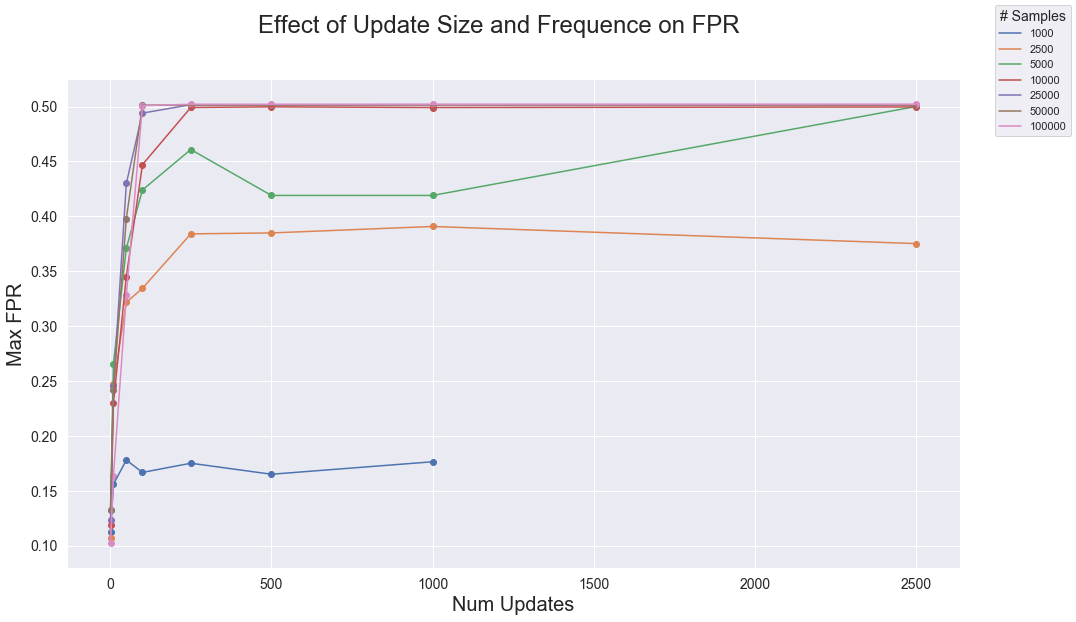

In [49]:
fig = plt.figure(figsize=(16,9))
fig.suptitle("Effect of Update Size and Frequence on FPR", fontsize=24)

ax = fig.add_subplot(111)
ax.set_ylabel("Max FPR", fontsize=20)
ax.set_xlabel("Num Updates", fontsize=20)

for count, i in enumerate(sizes):
    ax.plot(list(max_fprs[i].keys()), list(max_fprs[i].values()), label=str(i))
    ax.scatter(list(max_fprs[i].keys()), list(max_fprs[i].values()))

ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', title="# Samples", title_fontsize=14)
fig.show()

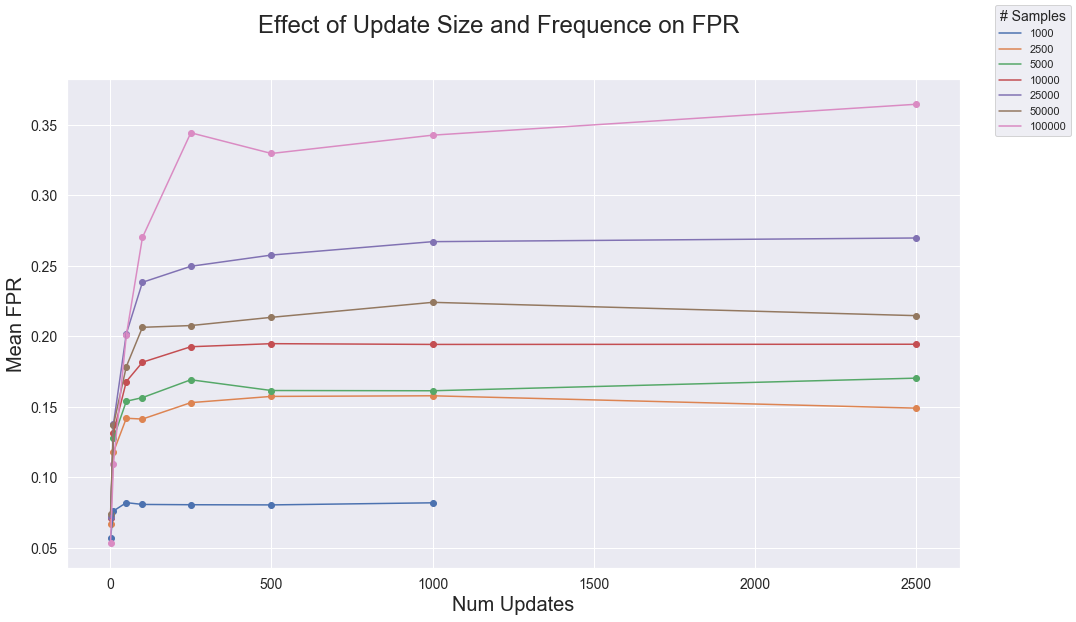

In [48]:
fig = plt.figure(figsize=(16,9))
fig.suptitle("Effect of Update Size and Frequence on FPR", fontsize=24)

ax = fig.add_subplot(111)
ax.set_ylabel("Mean FPR", fontsize=20)
ax.set_xlabel("Num Updates", fontsize=20)

for count, i in enumerate(sizes):
    ax.plot(list(mean_fprs[i].keys()), list(mean_fprs[i].values()), label=str(i))
    ax.scatter(list(mean_fprs[i].keys()), list(mean_fprs[i].values()))
#     ax.scatter(list(mean_fprs[i].keys()), list(max_fprs[i].values()))

ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', title="# Samples", title_fontsize=14)
fig.show()

## Fine Intervals

Asymptotically, it's clear that in the worst case, more samples and more updates means worse FPR. However, now let's understand the smaller regime of updates to see if this asymptotic behaviour holds in this domain as well

In [50]:
seeds = np.arange(10)
n_train = 10000
n_test = 50000
sizes = [1000, 2500, 5000, 10000, 25000, 50000, 100000]
updates = list(np.arange(0, 200, 5))[1:]

results = {size: {update: [] for update in updates} for size in sizes}


for seed in seeds:
    for size in sizes:
        for update in updates:
            if update > size:
                if update in results[size].keys():
                    del results[size][update]
                continue
            
            np.random.seed(seed)

            x, y = make_classification(n_train + size + n_test, n_informative=2, n_features=2, n_classes=2, n_clusters_per_class=2 ,n_redundant=0, flip_y=0, class_sep=1.0)
            x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=size + n_test)
            x_update, x_test, y_update, y_test = train_test_split(x_test, y_test, test_size=n_test)

            model = linear_model.SGDClassifier(max_iter=10000, tol=1e-3, warm_start=True, loss="log")
            model.fit(x_train, y_train)

            y_pred = model.predict(x_test)
            initial_tnr, initial_fpr, initial_fnr, initial_tpr = eval_model(y_test, y_pred)

            new_model = update_model_online_feedback(model, x_update, y_update, update)

            y_pred = new_model.predict(x_test)
            updated_tnr, updated_fpr, updated_fnr, updated_tpr = eval_model(y_test, y_pred)

            results[size][update].append(updated_fpr)

In [51]:
max_fprs = {}
mean_fprs = {}
std_fprs = {}

for size in sizes:
    max_fprs[size] = {}
    mean_fprs[size] = {}
    std_fprs[size] = {}
    
    for update in results[size].keys():
        max_fprs[size][update] = np.max(results[size][update])
        mean_fprs[size][update] = np.mean(results[size][update])
        std_fprs[size][update] = np.std(results[size][update])

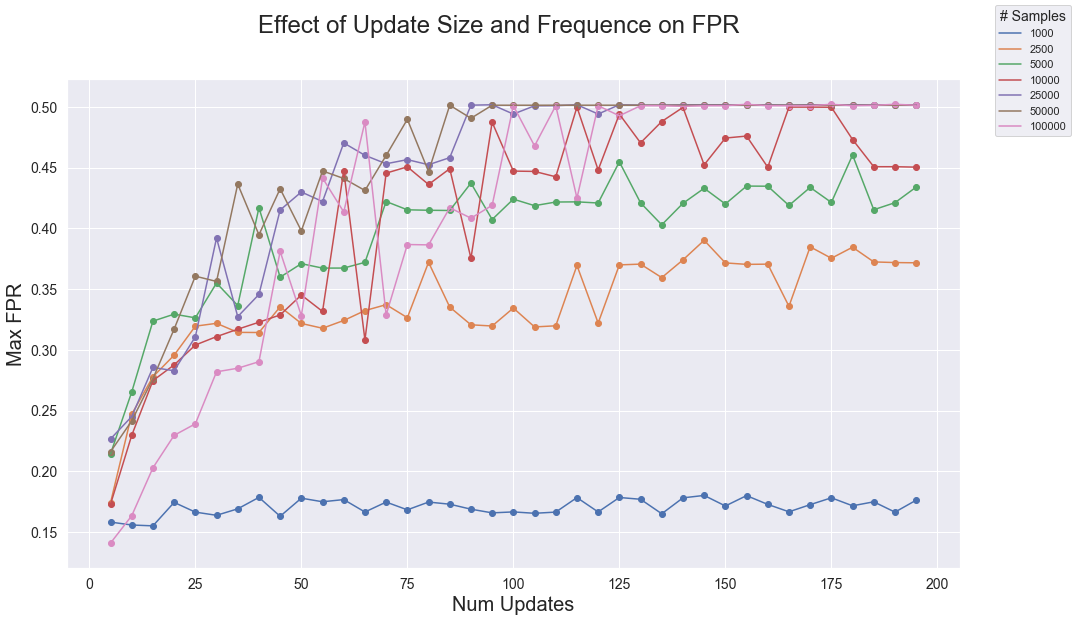

In [52]:
fig = plt.figure(figsize=(16,9))
fig.suptitle("Effect of Update Size and Frequence on FPR", fontsize=24)

ax = fig.add_subplot(111)
ax.set_ylabel("Max FPR", fontsize=20)
ax.set_xlabel("Num Updates", fontsize=20)

for count, i in enumerate(sizes):
    ax.plot(list(max_fprs[i].keys()), list(max_fprs[i].values()), label=str(i))
    ax.scatter(list(max_fprs[i].keys()), list(max_fprs[i].values()))

ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', title="# Samples", title_fontsize=14)
fig.show()

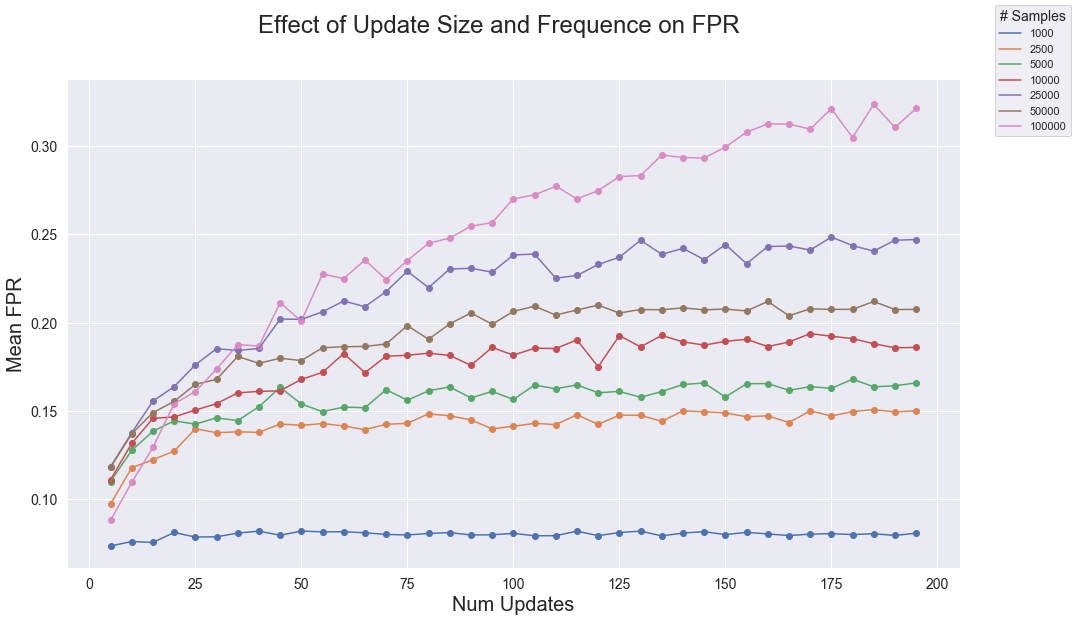

In [53]:
fig = plt.figure(figsize=(16,9))
fig.suptitle("Effect of Update Size and Frequence on FPR", fontsize=24)

ax = fig.add_subplot(111)
ax.set_ylabel("Mean FPR", fontsize=20)
ax.set_xlabel("Num Updates", fontsize=20)

for count, i in enumerate(sizes):
    ax.plot(list(mean_fprs[i].keys()), list(mean_fprs[i].values()), label=str(i))
    ax.scatter(list(mean_fprs[i].keys()), list(mean_fprs[i].values()))
#     ax.scatter(list(mean_fprs[i].keys()), list(max_fprs[i].values()))

ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', title="# Samples", title_fontsize=14)
fig.show()